# Introduction
## Using Google Search Volume and News Sentiment to Predict Natural Gas Prices with LSTMs
by Quinn Murphey, Adrian Ramos, and Gabriel Soliz

In [1]:
import os
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import skopt as skopt
import skopt.plots
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Data Fetch Stage

## US EIA NYMEX Dataset
TODO EXPLAIN DATASET

In [2]:
# Read csvs to dataframes
nymex_spot_df = pd.read_csv("data/US_EIA_NYMEX_spot.csv")
nymex_futures_df = pd.read_csv("data/US_EIA_NYMEX_futures.csv")

# Turn Date column into a datetime object rather than string
nymex_spot_df["Date"] = nymex_spot_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))
nymex_futures_df["Date"] = nymex_futures_df["Date"].map(lambda str : datetime.strptime(str, "%b %d, %Y"))

# Trim to Jan 2013 - Jun 2019
nymex_spot_df = nymex_spot_df[(nymex_spot_df["Date"] >= datetime(year=2013, month=1, day=1)) & (nymex_spot_df["Date"] <= datetime(year=2019, month=6, day=30))]
nymex_futures_df = nymex_futures_df[(nymex_futures_df["Date"] >= datetime(year=2013, month=1, day=1)) & (nymex_futures_df["Date"] <= datetime(year=2019, month=6, day=30))]

# Reset index
nymex_spot_df = nymex_spot_df.set_index("Date")
nymex_futures_df = nymex_futures_df.set_index("Date")

# Rename Columns
nymex_spot_df    = nymex_spot_df.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'Spot Price'})
nymex_futures_df = nymex_futures_df.rename(columns={'Natural Gas Futures Contract 1 (Dollars per Million Btu)':'Futures 1 Price','Natural Gas Futures Contract 2 (Dollars per Million Btu)':'Futures 2 Price','Natural Gas Futures Contract 3 (Dollars per Million Btu)':'Futures 3 Price','Natural Gas Futures Contract 4 (Dollars per Million Btu)':'Futures 4 Price'})

In [3]:
nymex_spot_df

,Spot Price
Date,
2013-01-02,3.30
2013-01-03,3.19
2013-01-04,3.20
2013-01-07,3.30
2013-01-08,3.21
...,...
2019-06-24,2.31
2019-06-25,2.31
2019-06-26,2.34


In [4]:
nymex_futures_df

,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,
2013-01-02,3.233,3.255,3.294,3.349
2013-01-03,3.198,3.214,3.250,3.306
2013-01-04,3.287,3.303,3.337,3.393
2013-01-07,3.266,3.281,3.318,3.374
2013-01-08,3.218,3.234,3.275,3.330
...,...,...,...,...
2019-06-24,2.303,2.284,2.256,2.291
2019-06-25,2.308,2.286,2.260,2.294
2019-06-26,2.291,2.268,2.244,2.275


## Google Trends Dataset

### PyTrends Scraper

In [5]:
import pytrends
from pytrends.request import TrendReq
import time
pytrend = TrendReq()

def get_daily_trends_as_df(keywords, categories, timeframe, countries, search_type):
    # Get pytrend suggestions and store them in exact_keywords
    keywords_codes = [pytrend.suggestions(keyword=i)[0] for i in keywords] 
    df_CODES= pd.DataFrame(keywords_codes)
    exact_keywords = df_CODES['mid'].to_list()

    # Store keywords alongside their respective categories
    individual_exact_keyword = list(zip(*[iter(exact_keywords)]*1, categories))
    individual_exact_keyword = [list(x) for x in individual_exact_keyword]

    # Split timeframe into 6 month chunks
    timeframe_start, timeframe_end = timeframe.split(" ")
    start_date = date.fromisoformat(timeframe_start)
    end_date = date.fromisoformat(timeframe_end)
    dates = []
    while start_date < end_date:
        dates.append(start_date)
        start_date = start_date + relativedelta(months=6)
    dates.append(end_date + relativedelta(days=1))

    # Compute number of fetches required
    max_fetches = len(countries) * len(keywords) * (len(dates) - 1)
    curr_fetches = 0

    trend_dict = {}
    for country in countries:
        for keyword, category in individual_exact_keyword:
            trend_dict[keyword] = pd.DataFrame()
            for i in range(len(dates)-1):
                pytrend.build_payload(kw_list=[keyword], 
                                    timeframe = dates[i].isoformat() + " " + (dates[i + 1] - relativedelta(days=1)).isoformat(), 
                                    geo = country, 
                                    cat=category,
                                    gprop=search_type)
                curr_fetches += 1
                print("[" + "=" * math.floor(20 * curr_fetches / max_fetches - 1) +  ">" * min(math.floor(20 * curr_fetches / max_fetches), 1) + " " * (20 - math.floor(20 * curr_fetches / max_fetches)) + "] ",end='')
                print(f"{math.floor(10000 * curr_fetches / max_fetches)/100}% Complete!", end='\r')
                time.sleep(15) # sleep to prevent google shutting us down
                trend_dict[keyword] = pd.concat([trend_dict[keyword], pytrend.interest_over_time()], axis=0)
            i+=1
    df_trends = pd.concat(trend_dict, axis=1)

    df_trends.columns = df_trends.columns.droplevel(0) #drop outside header
    df_trends = df_trends.drop('isPartial', axis = 1) #drop "isPartial"
    df_trends.reset_index(level=0,inplace=True) #reset_index
    df_trends.columns = ['Date'] + keywords
    df_trends["Date"] = df_trends["Date"].map(lambda str : datetime.strptime(str, "%Y-%m-%d"))
    df_trends = df_trends.set_index("Date")

    return df_trends

In [6]:
KEYWORDS            = ["Natural Gas","Oil","Coal","Nuclear Power","Wind Power","Hydroelectric","Solar Power","Gold","Silver","Platinum","Copper","Biofuel","Recession","CPI"]
KEYWORDS_CATEGORIES = [904,          904,  904,   0,               0,          0,               0,           904,   904,     904,       904,     0,        0,          0]
TIMEFRAME='2013-01-02 2019-06-28' # Jan 2013 - June 2019
COUNTRIES=["US"] # ISO country code
SEARCH_TYPE='' #default is 'web searches',others include 'images','news','youtube','froogle' (google shopping)

try:
    google_trends_df = pd.read_csv("data/google_trends_dataset.csv")
    google_trends_df["Date"] = google_trends_df["Date"].map(lambda str : datetime.strptime(str, "%Y-%m-%d"))
    google_trends_df = google_trends_df.set_index("Date")
except:
    google_trends_df = get_daily_trends_as_df(KEYWORDS, KEYWORDS_CATEGORIES, TIMEFRAME, COUNTRIES, SEARCH_TYPE)
    google_trends_df.to_csv("data/google_trends_dataset.csv")

google_trends_df

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2013-01-02,62,95,0,20,60,28,52,23,50,31,72,47,49,55
2013-01-03,54,81,0,23,52,18,56,23,45,15,42,55,41,45
2013-01-04,68,78,27,19,54,23,51,23,43,100,58,37,51,45
2013-01-05,7,68,0,15,33,11,46,23,34,36,54,15,25,22
2013-01-06,21,54,0,17,34,19,48,17,34,30,45,33,39,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,25,60,0,47,24,18,69,89,85,43,76,100,37,53
2019-06-25,32,50,0,44,25,15,67,98,94,37,31,49,42,61
2019-06-26,25,44,0,41,20,6,67,87,75,43,79,31,35,59


## Financial Times Scraper

# Data Visualization

We will create a `plot` function that will be able to plot our data with, or without label and with or without predictions

In [7]:
def plot(data, units=None, feature_width=0, label_width=0, predictions=None, density=1, seperate=True, file=None):
    """
    data: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted
    units: if seperate is True, a list of strings, else a string
    feature_width: input width of time series window
    label_width: label width of time series window
    predictions: of the form of a dataframe, indexed by a datetime object, each column being a seperate series to be plotted (should match up with data column names)
    density: average every 'density' number of entries to end up plotting 1/density as many entries
    file: file to save figure to (None if no save)
    """
    # Verify units
    if units==None:
        units = [""] * len(data.columns)
    elif isinstance(units, str):
        units = [units] * len(data.columns)
    elif seperate and len(units) != len(data.columns):
        print("ERROR: Make sure units is the same length as data")
        return

    # Create new data if density != 1 using the mean of rolling windows
    if density != 1:
        # data
        first_row = data.iloc[0, :]
        last_row = data.iloc[-1, :] 
        data = data.rolling(density).mean().iloc[::density,:]
        data.iloc[0] = first_row
        data.iloc[-1] = last_row

        # predictions
        if predictions is not None:
            predictions = predictions.rolling(density).mean().loc[data.index.intersection(predictions.index),:]

    # Create a 12x12 figure
    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')

    # If plotting seperate Divide the fig into N subplots where N is the number of columns in data
    if seperate:
        ncols=math.ceil(math.sqrt(len(data.columns)))
        nrows=math.ceil( len(data.columns) / ncols)
    else: 
        plt.ylabel(units[0])
        plt.xlabel("Date")
    i = 1

    # Iterate over all columns in data
    for column, unit in zip(data.columns, units):
        # Label seperate subfigs
        if seperate:
            ax = plt.subplot(nrows,ncols,i)
            ax.set_title(column)
            plt.ylabel(unit)
            plt.xlabel('Date')
        i+=1

        # Plot data
        plt.plot(data.index,data[column], label=column)

        # Plot predictions
        if feature_width != 0 and label_width != 0 and column in predictions.columns:
            # plot as one long series if label width is 1
            if label_width == 1:
                plt.plot(predictions.index, predictions[column], label=column + " Predictions")

            # plot as a lot of series if label width is > 1
            else:
                pass
            
            if seperate:
                plt.legend()

    if not seperate:
        plt.legend()
    plt.tight_layout()
    if file:
        plt.savefig(file)
    else:
        plt.show()

# Data Preprocessing Stage

## NYMEX

### Join dataframes (by date)

In [8]:
nymex_df = pd.concat([nymex_spot_df, nymex_futures_df],axis=1)
nymex_df

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
Date,,,,,
2013-01-02,3.30,3.233,3.255,3.294,3.349
2013-01-03,3.19,3.198,3.214,3.250,3.306
2013-01-04,3.20,3.287,3.303,3.337,3.393
2013-01-07,3.30,3.266,3.281,3.318,3.374
2013-01-08,3.21,3.218,3.234,3.275,3.330
...,...,...,...,...,...
2019-06-24,2.31,2.303,2.284,2.256,2.291
2019-06-25,2.31,2.308,2.286,2.260,2.294
2019-06-26,2.34,2.291,2.268,2.244,2.275


However, there are some NaN values due to the dates covered differing

In [9]:
nymex_df.isna().sum()

Spot Price         19
Futures 1 Price    33
Futures 2 Price    33
Futures 3 Price    33
Futures 4 Price    33
dtype: int64

### Fill spot price voids 
Interpolate all voids linearly (by column)

In [10]:
nymex_df = nymex_df.interpolate(method='time')
nymex_df.isna().sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

### Interpolate Weekends and Holidays

In [11]:
nymex_df = nymex_df.reindex(pd.date_range(nymex_df.index[0],nymex_df.index[-1],freq='d'))
nymex_df


,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
2013-01-02,3.30,3.233,3.255,3.294,3.349
2013-01-03,3.19,3.198,3.214,3.250,3.306
2013-01-04,3.20,3.287,3.303,3.337,3.393
2013-01-05,NaN,NaN,NaN,NaN,NaN
2013-01-06,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2019-06-24,2.31,2.303,2.284,2.256,2.291
2019-06-25,2.31,2.308,2.286,2.260,2.294
2019-06-26,2.34,2.291,2.268,2.244,2.275
2019-06-27,2.32,2.324,2.298,2.325,2.413


In [12]:
nymex_df = nymex_df.interpolate(method='time')
nymex_df.isna().sum()

Spot Price         0
Futures 1 Price    0
Futures 2 Price    0
Futures 3 Price    0
Futures 4 Price    0
dtype: int64

### Plot NYMEX Data (note the exponential nature to it)

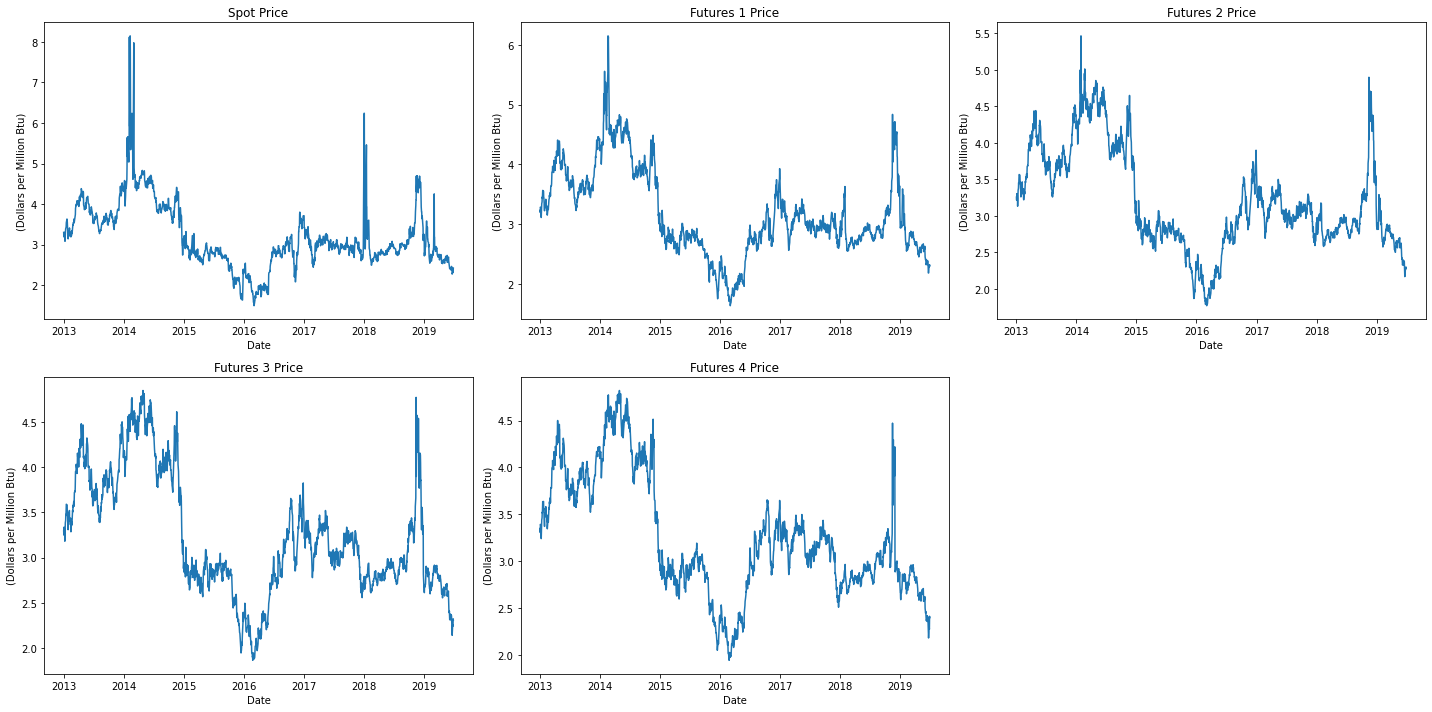

In [13]:
plot(nymex_df,units="(Dollars per Million Btu)", seperate=True, density=1, file="images/nymex_data.png")

### Normalize columns
First log all values: $x' = \log{x}$, then normalize: $x' = (x - \mu)/\sigma$

Check for negative values

In [14]:
means = {}
stds = {} 

def normalize_nymex(nymex_df):
    assert (nymex_df <= 0).sum().sum() == 0
    global means
    global stds

    nymex_df_normalized = np.log(nymex_df)
    for column in nymex_df_normalized.columns:
        means[column] = nymex_df_normalized[column].mean()
        stds[column] = nymex_df_normalized[column].std()
        nymex_df_normalized[column] = (nymex_df_normalized[column] - means[column]) / stds[column]
    
    return nymex_df_normalized

def restore_nymex(nymex_df_normalized):
    global means
    global stds

    for column in nymex_df_normalized:
        nymex_df_normalized[column] = nymex_df_normalized[column] * stds[column] + means[column]
    nymex_df = np.exp(nymex_df_normalized)
    return nymex_df

Log each value and Normalize each row

In [15]:
nymex_df_normalized = normalize_nymex(nymex_df)
nymex_df_normalized

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price
2013-01-02,0.254080,0.197720,0.183293,0.195539,0.253670
2013-01-03,0.114006,0.148998,0.123394,0.129185,0.186952
2013-01-04,0.126938,0.271867,0.252468,0.259534,0.321058
2013-01-05,0.169755,0.262325,0.241965,0.250160,0.311413
2013-01-06,0.212132,0.252762,0.231438,0.240768,0.301749
...,...,...,...,...,...
2019-06-24,-1.219618,-1.320588,-1.490744,-1.672109,-1.706515
2019-06-25,-1.219618,-1.310881,-1.486608,-1.663368,-1.699759
2019-06-26,-1.166304,-1.343973,-1.523963,-1.698425,-1.742698
2019-06-27,-1.201770,-1.279957,-1.461867,-1.523457,-1.438656


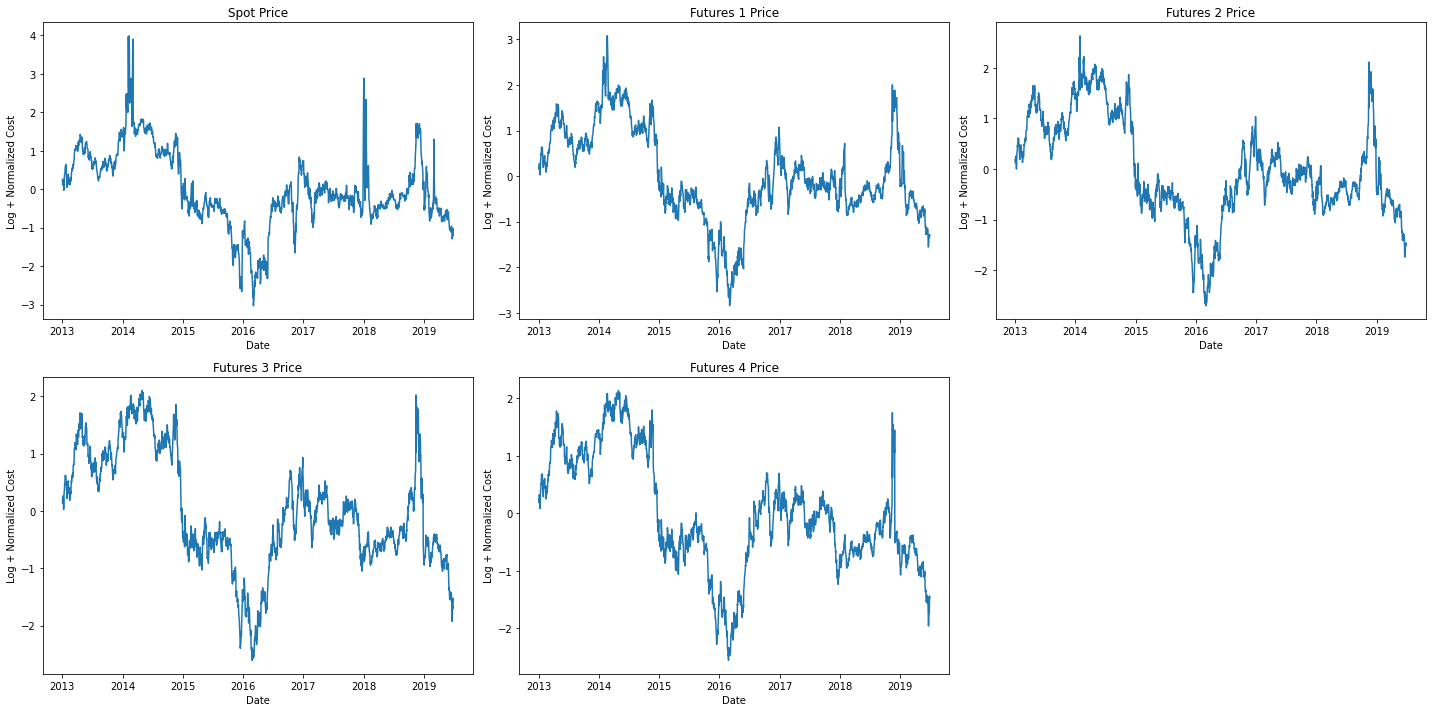

In [16]:
plot(nymex_df_normalized,units="Log + Normalized Cost", seperate=True, density=1, file="images/nymex_data_normalized.png")

## Google Trends

### Plot Google Trends data

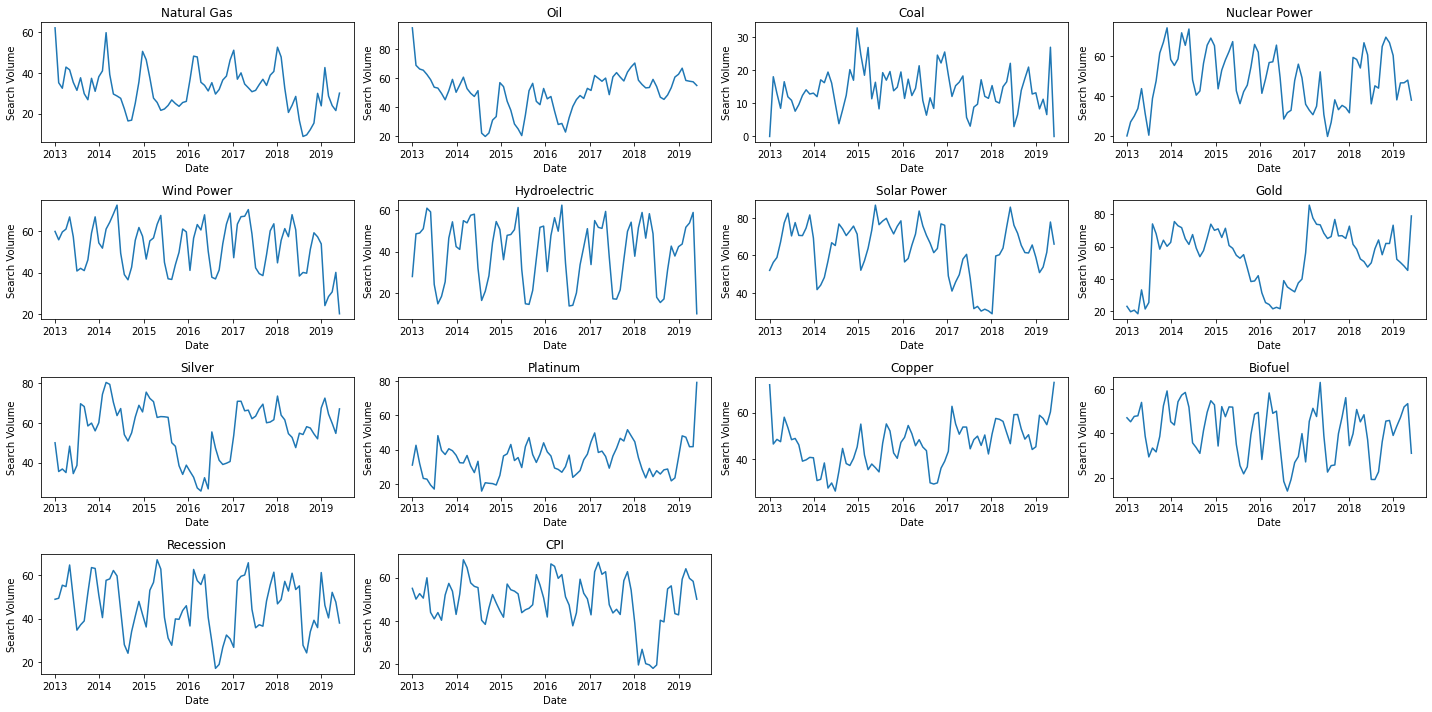

In [17]:
plot(google_trends_df,units="Search Volume", seperate=True, density=30, file="images/google_trends_data.png")

### Normalize Columns 
$x' = (x- \mu)/\sigma$

In [18]:
google_trends_df_normalized = google_trends_df.copy()

for column in google_trends_df_normalized.columns:
    google_trends_df_normalized[column] = (google_trends_df_normalized[column] - google_trends_df_normalized[column].mean()) / google_trends_df_normalized[column].std()

google_trends_df_normalized

,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
Date,,,,,,,,,,,,,,
2013-01-02,1.503944,2.432720,-0.636195,-1.518174,0.414909,-0.500199,-0.733564,-1.593181,-0.354614,-0.160893,1.468856,0.300652,0.167734,0.268924
2013-01-03,1.105577,1.678089,-0.636195,-1.360954,-0.006290,-0.898831,-0.488534,-1.593181,-0.657870,-1.041544,-0.221943,0.687794,-0.258221,-0.201768
2013-01-04,1.802719,1.516383,0.561079,-1.570580,0.099010,-0.699515,-0.794822,-1.593181,-0.779173,3.636912,0.679817,-0.183276,0.274223,-0.201768
2013-01-05,-1.234828,0.977361,-0.636195,-1.780206,-1.006635,-1.177873,-1.101109,-1.593181,-1.325034,0.114310,0.454377,-1.247916,-1.110130,-1.284358
2013-01-06,-0.537686,0.222730,-0.636195,-1.675393,-0.953985,-0.858968,-0.978594,-1.903559,-1.325034,-0.215934,-0.052863,-0.376847,-0.364709,-1.049012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,-0.338503,0.546143,-0.636195,-0.103198,-1.480483,-0.898831,0.307813,1.820975,1.768180,0.499594,1.694296,2.865468,-0.471198,0.174786
2019-06-25,0.010068,0.007122,-0.636195,-0.260418,-1.427833,-1.018420,0.185298,2.286542,2.314042,0.169350,-0.841902,0.397437,-0.204976,0.551339
2019-06-26,-0.338503,-0.316291,-0.636195,-0.417637,-1.691082,-1.377189,0.185298,1.717516,1.161668,0.499594,1.863375,-0.473632,-0.577687,0.457201


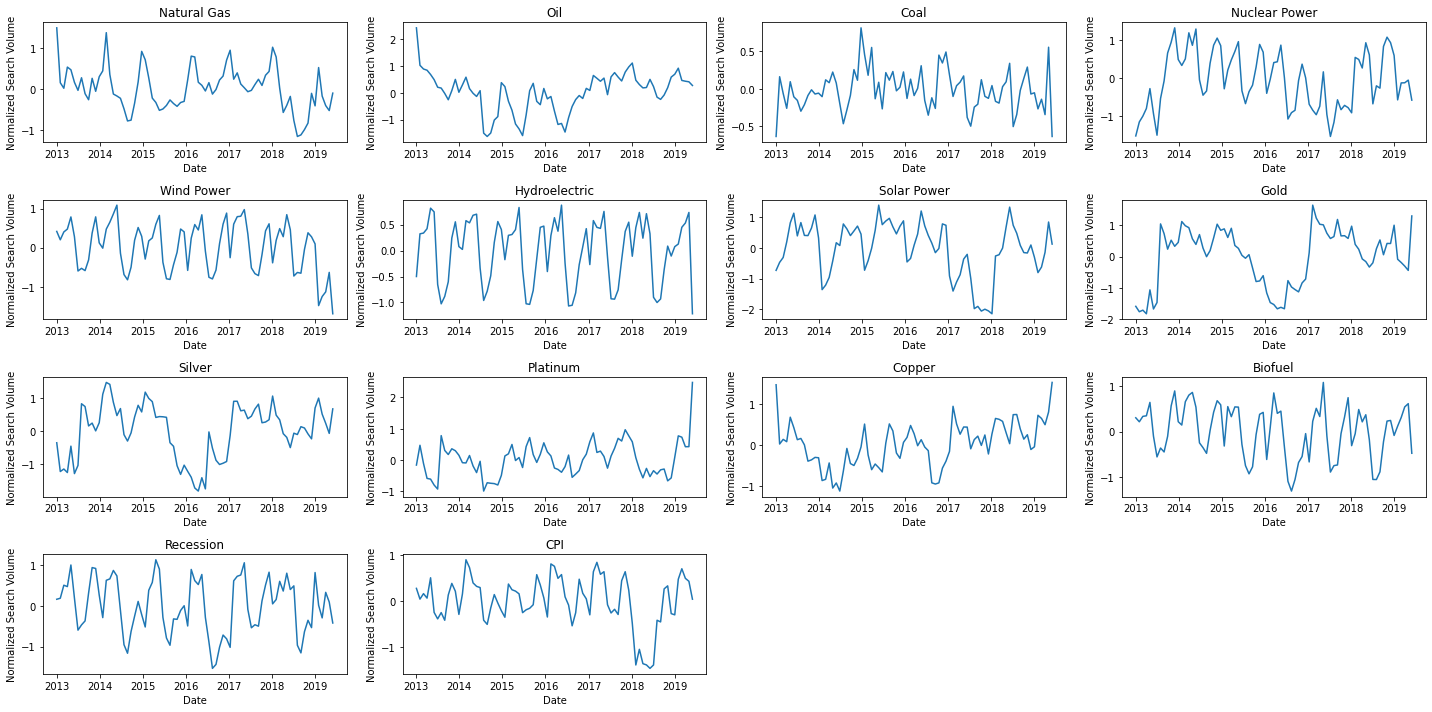

In [19]:
plot(google_trends_df_normalized,units="Normalized Search Volume", seperate=True, density=30, file="images/google_trends_data_normalized.png")

# Create Tensorflow Dataset

### Join NYMEX and Google Datasets

In [20]:
full_df = pd.concat([nymex_df_normalized, google_trends_df_normalized],axis=1)
full_df

,Spot Price,Futures 1 Price,Futures 2 Price,Futures 3 Price,Futures 4 Price,Natural Gas,Oil,Coal,Nuclear Power,Wind Power,Hydroelectric,Solar Power,Gold,Silver,Platinum,Copper,Biofuel,Recession,CPI
2013-01-02,0.254080,0.197720,0.183293,0.195539,0.253670,1.503944,2.432720,-0.636195,-1.518174,0.414909,-0.500199,-0.733564,-1.593181,-0.354614,-0.160893,1.468856,0.300652,0.167734,0.268924
2013-01-03,0.114006,0.148998,0.123394,0.129185,0.186952,1.105577,1.678089,-0.636195,-1.360954,-0.006290,-0.898831,-0.488534,-1.593181,-0.657870,-1.041544,-0.221943,0.687794,-0.258221,-0.201768
2013-01-04,0.126938,0.271867,0.252468,0.259534,0.321058,1.802719,1.516383,0.561079,-1.570580,0.099010,-0.699515,-0.794822,-1.593181,-0.779173,3.636912,0.679817,-0.183276,0.274223,-0.201768
2013-01-05,0.169755,0.262325,0.241965,0.250160,0.311413,-1.234828,0.977361,-0.636195,-1.780206,-1.006635,-1.177873,-1.101109,-1.593181,-1.325034,0.114310,0.454377,-1.247916,-1.110130,-1.284358
2013-01-06,0.212132,0.252762,0.231438,0.240768,0.301749,-0.537686,0.222730,-0.636195,-1.675393,-0.953985,-0.858968,-0.978594,-1.903559,-1.325034,-0.215934,-0.052863,-0.376847,-0.364709,-1.049012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,-1.219618,-1.320588,-1.490744,-1.672109,-1.706515,-0.338503,0.546143,-0.636195,-0.103198,-1.480483,-0.898831,0.307813,1.820975,1.768180,0.499594,1.694296,2.865468,-0.471198,0.174786
2019-06-25,-1.219618,-1.310881,-1.486608,-1.663368,-1.699759,0.010068,0.007122,-0.636195,-0.260418,-1.427833,-1.018420,0.185298,2.286542,2.314042,0.169350,-0.841902,0.397437,-0.204976,0.551339
2019-06-26,-1.166304,-1.343973,-1.523963,-1.698425,-1.742698,-0.338503,-0.316291,-0.636195,-0.417637,-1.691082,-1.377189,0.185298,1.717516,1.161668,0.499594,1.863375,-0.473632,-0.577687,0.457201
2019-06-27,-1.201770,-1.279957,-1.461867,-1.523457,-1.438656,-0.189115,0.330535,-0.636195,-0.732076,-1.164585,-0.699515,0.124041,1.200219,1.101016,1.875611,1.243416,-0.909167,-0.098487,0.504270


### Dataframe to Window Dataset function

In [21]:
def df_to_ds(df, features, labels, feature_width=7, label_width=1, label_dates=None):
    """
    df : dataframe with a datetime index
    features : columns of df designated to be features
    labels : columns of df designmated to be labels
    feature_width : time-width of features in window
    label_width : time-width of labels in window
    label_dates : restrict the labels to come from this index
    """
    if label_dates is None:
        label_dates = df.index[feature_width:-(label_width)]

    feature_array = np.ndarray((len(label_dates),feature_width,len(features)),dtype=np.float64) # window, time, feature
    label_array = np.ndarray((len(label_dates),label_width,len(labels)),dtype=np.float64) # window, time, feature

    # Loop over all label start dates
    i = 0
    for label_start_date in (x for x in pd.date_range(df.index[0] + relativedelta(days=feature_width), df.index[-1] - relativedelta(days=label_width - 1),freq='d') if x in label_dates):
        # Loop over all features dates of current feature, label pair
        j = 0
        for feature_date in pd.date_range(label_start_date - relativedelta(days=feature_width), label_start_date - relativedelta(days=1),freq='d'):
            feature_array[i,j,:] = df.loc[feature_date][features].values
            j += 1

        j = 0
        # Loop over all label dates of current feature, label pair
        for label_date in pd.date_range(label_start_date, label_start_date + relativedelta(days=label_width - 1), freq='d'):
            label_array[i,j,:] = df.loc[label_date][labels].values
            j += 1

        i += 1

    # Turn np arrays into tf datasets
    feature_dataset = tf.data.Dataset.from_tensor_slices(feature_array)
    label_dataset = tf.data.Dataset.from_tensor_slices(label_array)

    # Zip datasets together into feature, label pairs
    dataset = tf.data.Dataset.zip((feature_dataset, label_dataset))

    return dataset

### Train Validate Test Dataset Split Function

In [22]:
def train_val_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, batch_size=8, repeats=1):
    """
    ds: tensorflow zip dataset
    train_split : 
    val_split :
    test_split :
    shuffle : whether to shuffle the ds or not
    """
    assert (train_split + val_split + test_split) == 1
    shuffle_size=10000
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=0)
    
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size).repeat(repeats).batch(batch_size)
    val_ds = ds.skip(train_size).take(val_size).repeat(repeats).batch(batch_size)
    test_ds = ds.skip(train_size).skip(val_size).repeat(repeats).batch(batch_size)
    
    return train_ds, val_ds, test_ds

### Finalize Dataset

In [23]:
FEATURES = full_df.columns
LABELS = ['Futures 1 Price','Futures 2 Price','Futures 3 Price','Futures 4 Price']
FEATURE_WIDTH = 7
LABEL_WIDTH   = 1
LABEL_DATES = full_df.index[FEATURE_WIDTH:-(LABEL_WIDTH - 1)] if LABEL_WIDTH > 1 else full_df.index[FEATURE_WIDTH:]

TRAIN_SPLIT = 0.8
VAL_SPLIT   = 0.1
TEST_SPLIT  = 0.1
BATCH_SIZE  = 8
REPEATS     = 1

dataset = df_to_ds(full_df, features=FEATURES, labels=LABELS, feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, label_dates=LABEL_DATES)
train_ds, val_ds, test_ds = train_val_test_split(dataset, train_split=TRAIN_SPLIT, val_split=VAL_SPLIT, test_split=TEST_SPLIT, batch_size=BATCH_SIZE, repeats=REPEATS)

# Model Training Stage

### Predictions Function
Returns predictions df from a given dataset and model

In [33]:
def get_predictions_df(model, dataset, label_width, labels, index):
    predictions = np.ndarray((len(dataset), label_width, len(labels)))
    dataset = dataset.batch(1)

    for i, tensor in enumerate(iter(dataset)):
        predictions[i,:,:] = model(tensor[0]).numpy()

    # get rid of time dim
    if label_width == 1:
        predictions = predictions.reshape((len(dataset), len(labels)))
    else: # compress time dim
        pass

    predictions_df = pd.DataFrame(predictions, index=index, columns=labels)
    predictions_df = restore_nymex(predictions_df)
    return predictions_df

### Create Model Function
Creates a custom LSTM model from a set of parameters

In [25]:
def create_model():
    pass

### Fitness Function (for evaluating hyperparameters)

In [27]:
MAX_EPOCHS = 40

dim_learning_rate = skopt.space.Real(low=1e-6, high=1e-1, prior='log-uniform', name='learning_rate')
dim_feature_width = skopt.space.Integer(low=1, high=365, name='feature_width')
dim_num_lstm_layers = skopt.space.Integer(low=1, high=5, name='num_lstm_layers')
dim_num_lstm_nodes = skopt.space.Integer(low=5, high=2048, name='num_lstm_nodes')

dimensions = [
    dim_learning_rate,
    dim_feature_width,
    dim_num_lstm_layers,
    dim_num_lstm_nodes
]

@skopt.utils.use_named_args(dimensions=dimensions)
def fitness(learning_rate, feature_width, num_lstm_layers, num_lstm_nodes):
    pass

### Perform Baesian Hyperparameter Search

In [28]:
best_loss = np.inf



In [29]:
stackedLstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(1024, return_sequences=False),
    tf.keras.layers.Dense(units=LABEL_WIDTH*len(LABELS)),
    tf.keras.layers.Reshape([LABEL_WIDTH, -1])
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=3,
                                                mode='min')

stackedLstm.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(learning_rate=0.5e-3),
            metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])

history = stackedLstm.fit(train_ds, epochs=100,
                  validation_data=val_ds,
                 callbacks=[early_stopping]) 

Epoch 1/100
237/237 [==============================] - 3s 5ms/step - loss: 0.0463 - mean_absolute_error: 0.1487 - root_mean_squared_error: 0.2151 - val_loss: 0.0347 - val_mean_absolute_error: 0.1474 - val_root_mean_squared_error: 0.1863
Epoch 2/100
237/237 [==============================] - 1s 4ms/step - loss: 0.0214 - mean_absolute_error: 0.1104 - root_mean_squared_error: 0.1463 - val_loss: 0.0177 - val_mean_absolute_error: 0.0962 - val_root_mean_squared_error: 0.1329
Epoch 3/100
237/237 [==============================] - 1s 4ms/step - loss: 0.0165 - mean_absolute_error: 0.0945 - root_mean_squared_error: 0.1284 - val_loss: 0.0192 - val_mean_absolute_error: 0.1034 - val_root_mean_squared_error: 0.1386
Epoch 4/100
237/237 [==============================] - 1s 4ms/step - loss: 0.0142 - mean_absolute_error: 0.0877 - root_mean_squared_error: 0.1192 - val_loss: 0.0134 - val_mean_absolute_error: 0.0822 - val_root_mean_squared_error: 0.1156
Epoch 5/100
237/237 [==============================]

In [30]:
stackedLstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4276224   
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
 reshape (Reshape)           (None, 1, 4)              0         
                                                                 
Total params: 4,280,324
Trainable params: 4,280,324
Non-trainable params: 0
_________________________________________________________________


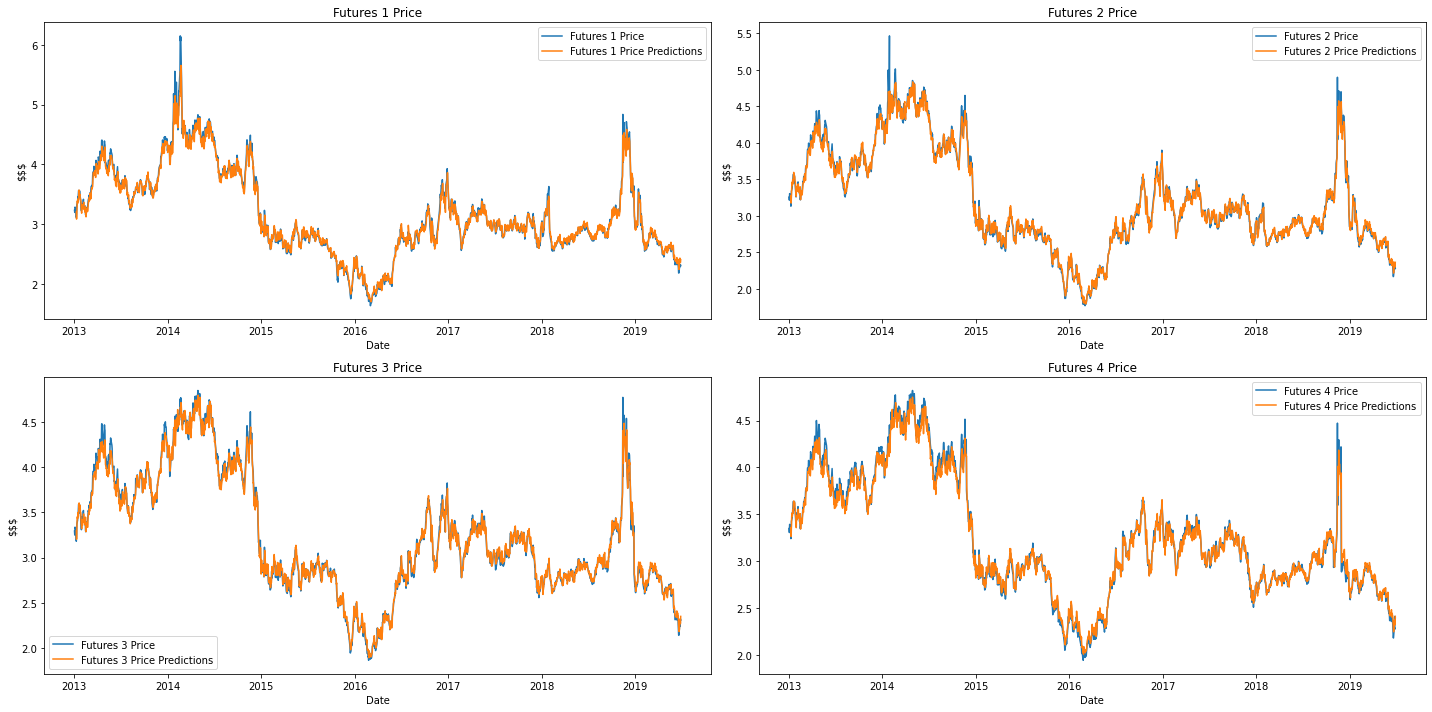

In [34]:
predictions_df = get_predictions_df(model=stackedLstm, dataset=dataset, label_width=LABEL_WIDTH, labels=LABELS, index=LABEL_DATES)
plot(nymex_df[LABELS], units="$$$", feature_width=FEATURE_WIDTH, label_width=LABEL_WIDTH, predictions=predictions_df, density=1, seperate=True, file=None)

# Model Testing Stage